# Модель, прогнозирующая отток клиентов банка «Бета-Банк»

 Целью нашей работы является выявление наиболее эффективной модели, прогнозирующей уход клиента из банка. В нашем распоряжении исторические данные таблицы о поведении клиентов и расторжении договоров с банком.
 
 Целевым признаком является столбец **"Exited"**, который фиксирует факт расторжение договора - значение `1`, или действующий договор клиент с банком - значение `0`. Перед нами стоит задача классификации бинарного распределения.
 
 На первом этапе работы мы изучим данные, проработаем признаки для подготовки их к обучению. Разделим датасет на три части: на обучающую, тестовую и валидационную выборки.
 
 Далее проведем обучение модели и проверку модели по обучающей и валидационной выборке без использования балансировки классов в целевой признаке. Для оценки модели мы выберем F1-меру для задачи классификации. 
 
 На третьем этапе работы проведем балансировку классов целевого признака, попытаемся улучшить наш результат, который также будет оценен метрикой F1-score.
 
 После определим лучшую модель и, воспользовавшись тестовой выборкой, найдем значение F1-меры протестируем нашу модель, важно довести значение метрики до 0.59. Это будет считаться успешной модель, которая будет эффективно работать для предсказания поведения клиента уже в боевых условиях.

## Анализ данных и работу над признаками датасета

### Анализ данных клиентов

Подготовим и импортируем инструменты для нашей работы.

In [1]:
!pip install optuna

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import optuna
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.compose import make_column_transformer

Ссылка на репозиторий в GitHub: https://github.com/romakulikov/fproject_gh.git

Создадим переменную `df_churn`, передадим в нее данные о клиентах.

In [3]:
try:
    df_churn = pd.read_csv('C://Users//roma_//OneDrive//Рабочий стол//DATA//Проект Бета-Банк//Churn.csv')
except:
    df_churn = pd.read_csv('/datasets/Churn.csv')

Познакомимся с данными с помощью функций `head()` и `info()`.

In [4]:
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Использовав сочетание функций `duplicated()` и `sum()`, найдем явные дубликаты в данных.

In [6]:
df_churn.duplicated().sum()

0

Для поиска неявных дубликатов обратимся к столбцу `'Surname'`, выведем на экран совпадения по данному столбцу. 

In [7]:
df_churn['Surname'].value_counts().head(10)

Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
Yeh         25
Shih        25
Genovese    25
Maclean     24
Wright      24
Name: Surname, dtype: int64

В таблице типичное распределение фамилий, действительно, фамилии Смит, Скотт, Мартин являются очень распространенными фамилиями, можем заключить об отсутствии дубликатов в данных датасета.

Только в столбце `Tenure` мы видим пропуски в данных, обратимся к ним напрямую, постараемся найти какую-то закономерность в них.

In [8]:
df_churn[df_churn['Tenure'].isna()].head(20)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Уточним количество количество объектов положительного класса среди всех объектов с пропусками в столбце `Tenure`.

In [9]:
df_churn[(df_churn['Tenure'].isna()) & (df_churn['Exited'] == 1)].shape[0]

183

In [10]:
df_churn['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Количество весьма ощутимое в отношение всего количества объектов положительного класса.

По видимому в объектах таблицы с пропусками в столбце `Tenure` нет ничего общего, нет кандидатуры для замены пропусков значениями без искажения данных, сам же столбец не может быть настолько показателен для определения целевого признака, удалим данный столбец, поскольку положительный класс гораздо ценнее.

In [11]:
df_churn = df_churn.drop(['Tenure'], axis=1)

Рассмотрим позиции в столбце `Geography`.

In [12]:
df_churn['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Признак содержит всего три вариации, сохраним его в окончательном варианте набора признаков для обучения и проверки модели. 

Далее проиллюстрируем баланс распределение бинарных значение в столбце целевого признака.

In [13]:
df_churn['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Как и предполагалось, в целевой признаке обнаружил себя явный дисбаланс, большинство - около 80% - клиентов остаються с банком. Нам важно это учесть в дальнейшем. 

Перейдем к обзору количественных переменных в данных. Построим графики распределения данных признаков.

Столбец `CreditScore`, который отражает кредитный рейтинг клиентов банка:

In [14]:
df_churn['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

C:\Users\roma_\AppData\Local\Temp\ipykernel_9096\2406137780.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)


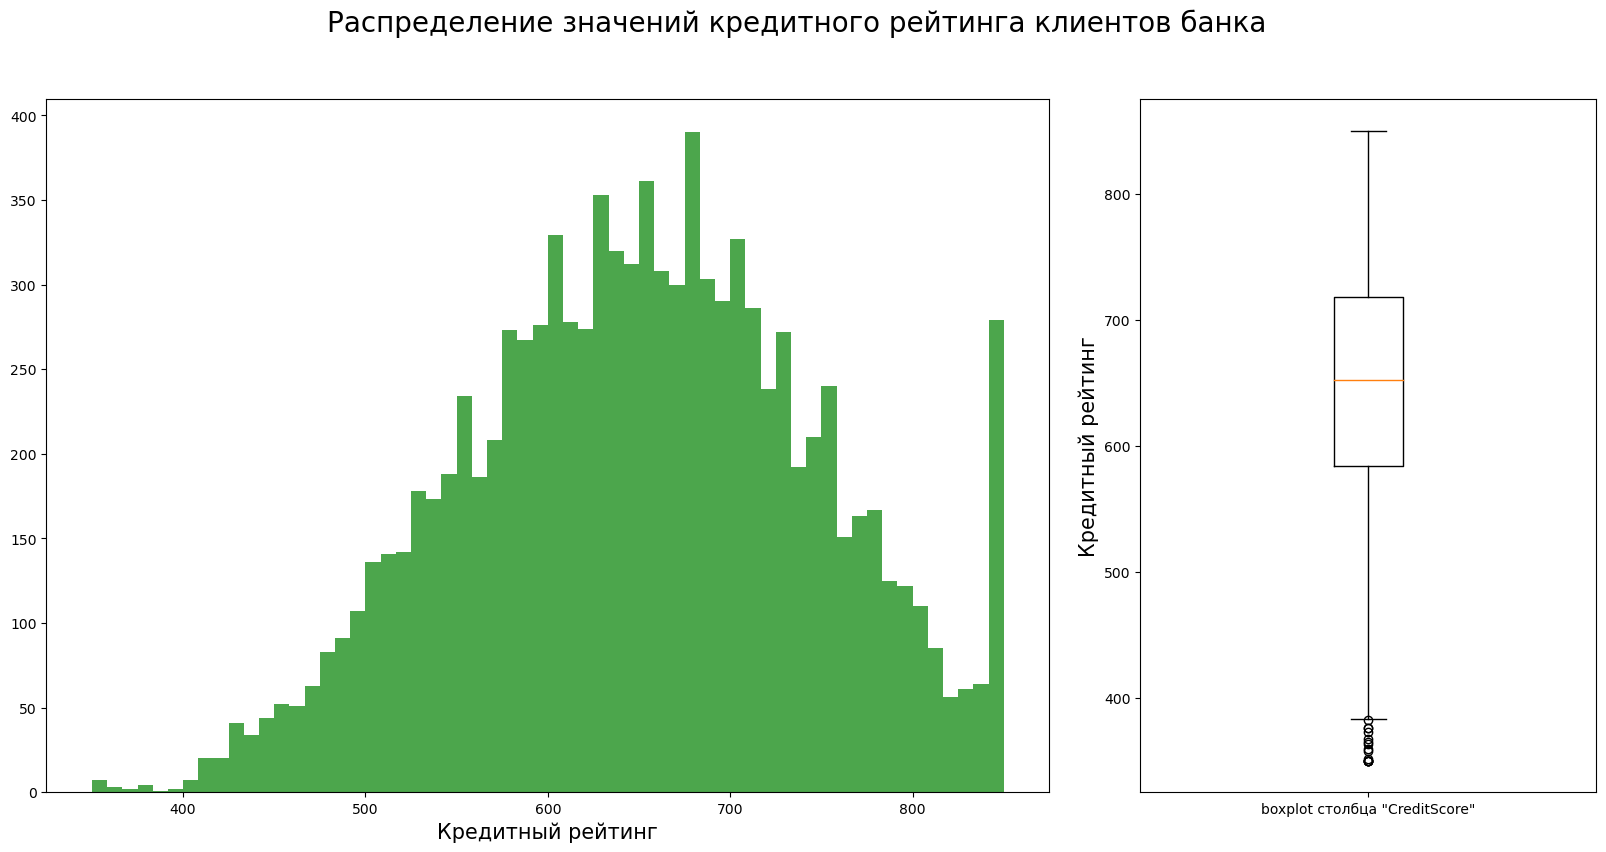

In [15]:
fig, (ax_1, ax_2) = plt.subplots(2, figsize=(20, 9))

fig.suptitle('Распределение значений кредитного рейтинга клиентов банка', fontsize=20)

ax_1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)
ax_2 = plt.subplot2grid((3, 3), (0, 2), rowspan=3)

ax_1.hist(df_churn['CreditScore'], 60, facecolor='g', alpha=0.7)
ax_2.boxplot(df_churn['CreditScore'])

plt.xticks([1], ['boxplot столбца "CreditScore"'])

ax_1.set_xlabel('Кредитный рейтинг', fontsize=15)
ax_2.set_ylabel('Кредитный рейтинг', fontsize=15)

plt.show()

Распределение значения кредитного рейтинга имеет нормальный вид. Очевидно, что существует предельная кредитная оценка в значении 850 единиц. 

Столбец `'Age'`.

In [16]:
df_churn['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

C:\Users\roma_\AppData\Local\Temp\ipykernel_9096\320704584.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)


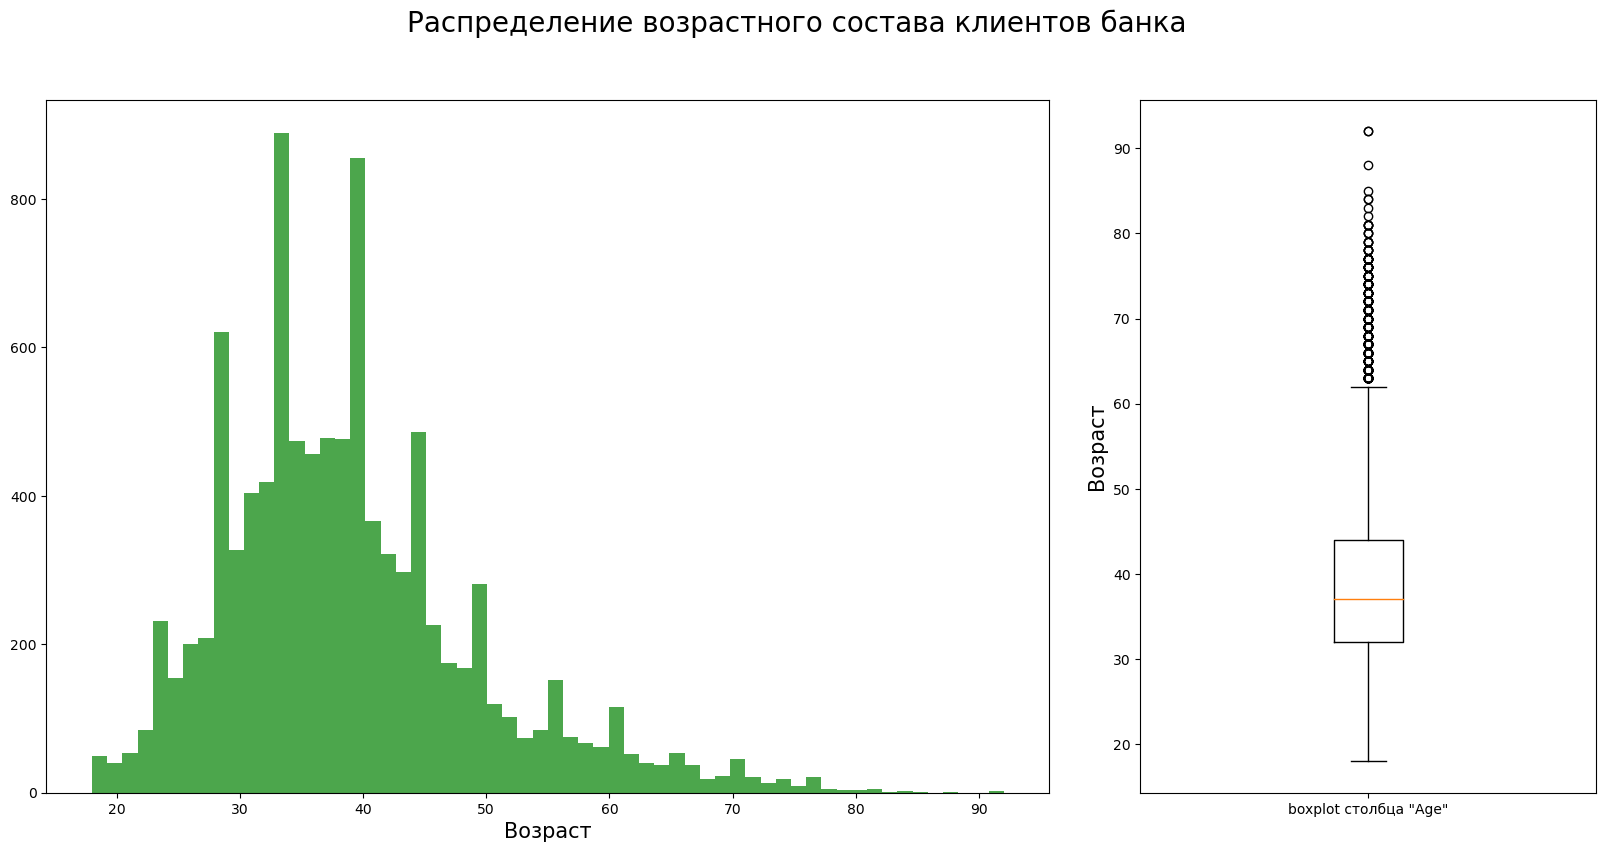

In [17]:
fig, (ax_1, ax_2) = plt.subplots(2, figsize=(20, 9))

fig.suptitle('Распределение возрастного состава клиентов банка', fontsize=20)

ax_1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)
ax_2 = plt.subplot2grid((3, 3), (0, 2), rowspan=3)

ax_1.hist(df_churn['Age'], 60, facecolor='g', alpha=0.7)
ax_2.boxplot(df_churn['Age'])

plt.xticks([1], ['boxplot столбца "Age"'])

ax_1.set_xlabel('Возраст', fontsize=15)
ax_2.set_ylabel('Возраст', fontsize=15)

plt.show()

Распределение также имеет нормальный вид, со скошенностью данных вправо, и минимальным возрастным пределом для клиента банка - 18 лет. 

Следующий столбец `'Balance'`, который сообщает о остатке на счете клиентов банка.

In [18]:
df_churn['Balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64

C:\Users\roma_\AppData\Local\Temp\ipykernel_9096\1221502517.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)


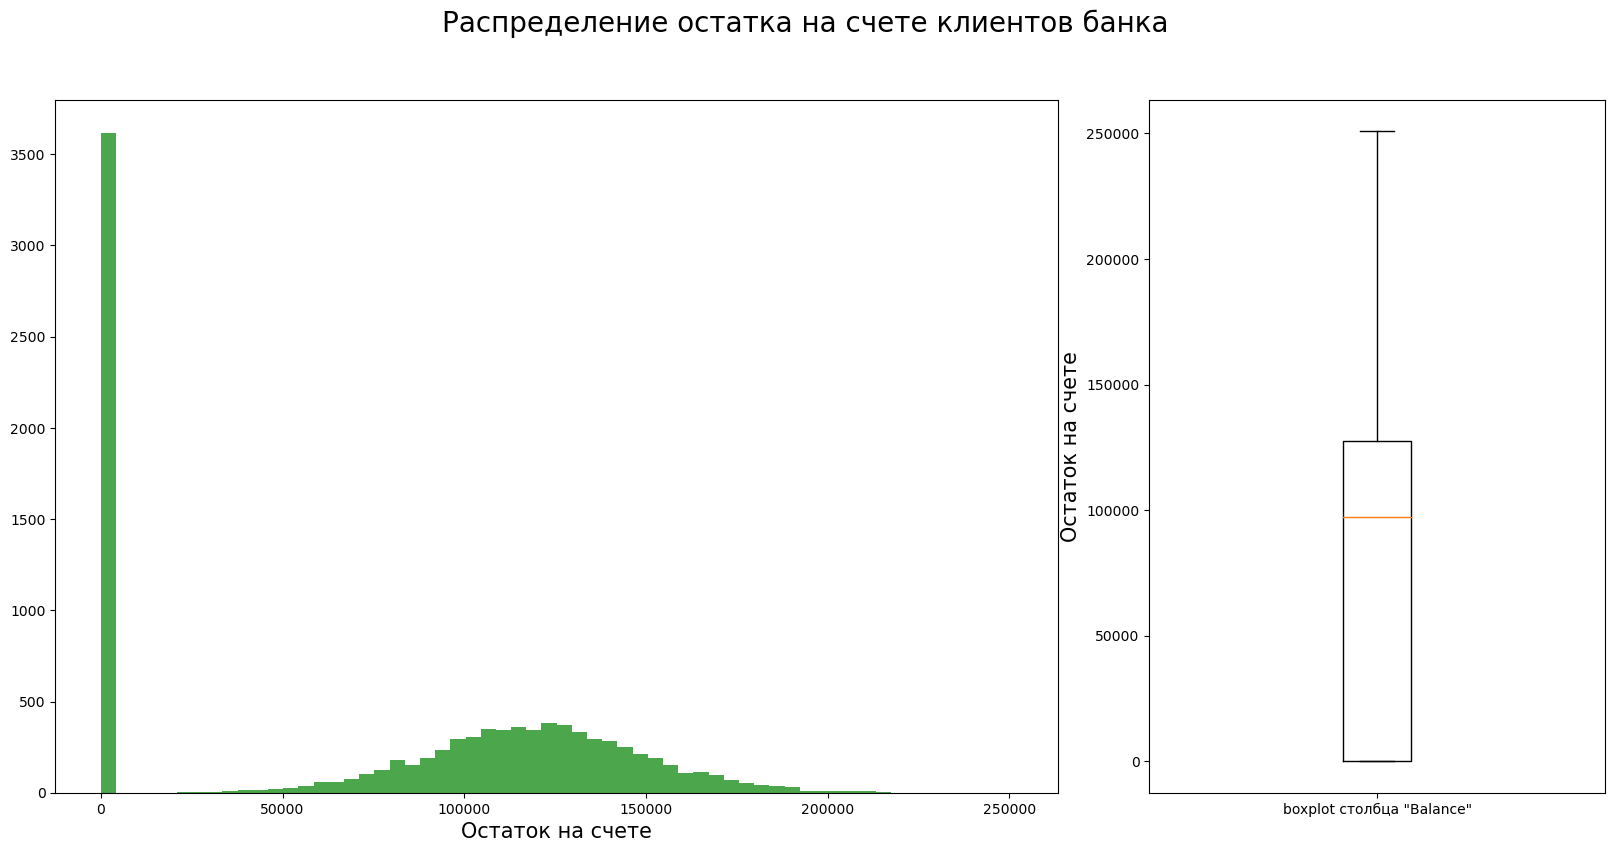

In [19]:
fig, (ax_1, ax_2) = plt.subplots(2, figsize=(20, 9))

fig.suptitle('Распределение остатка на счете клиентов банка', fontsize=20)

ax_1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)
ax_2 = plt.subplot2grid((3, 3), (0, 2), rowspan=3)

ax_1.hist(df_churn['Balance'], 60, facecolor='g', alpha=0.7)
ax_2.boxplot(df_churn['Balance'])

plt.xticks([1], ['boxplot столбца "Balance"'])

ax_1.set_xlabel('Остаток на счете', fontsize=15)
ax_2.set_ylabel('Остаток на счете', fontsize=15)

plt.show()

Как видим из гистограммы, внушительная часть клиентов имеет нулевой остаток на счете (зафиксировано более 3500 счетов без средств на них). Статистически - это, конечно, аномалия, на практике же довольно распространенное явление, и показатель нулевого остатка будет будет важным для нашей модели, потому оставим данные в столбце в оригинальном значении. В остальном распределение носит нормальный характер:

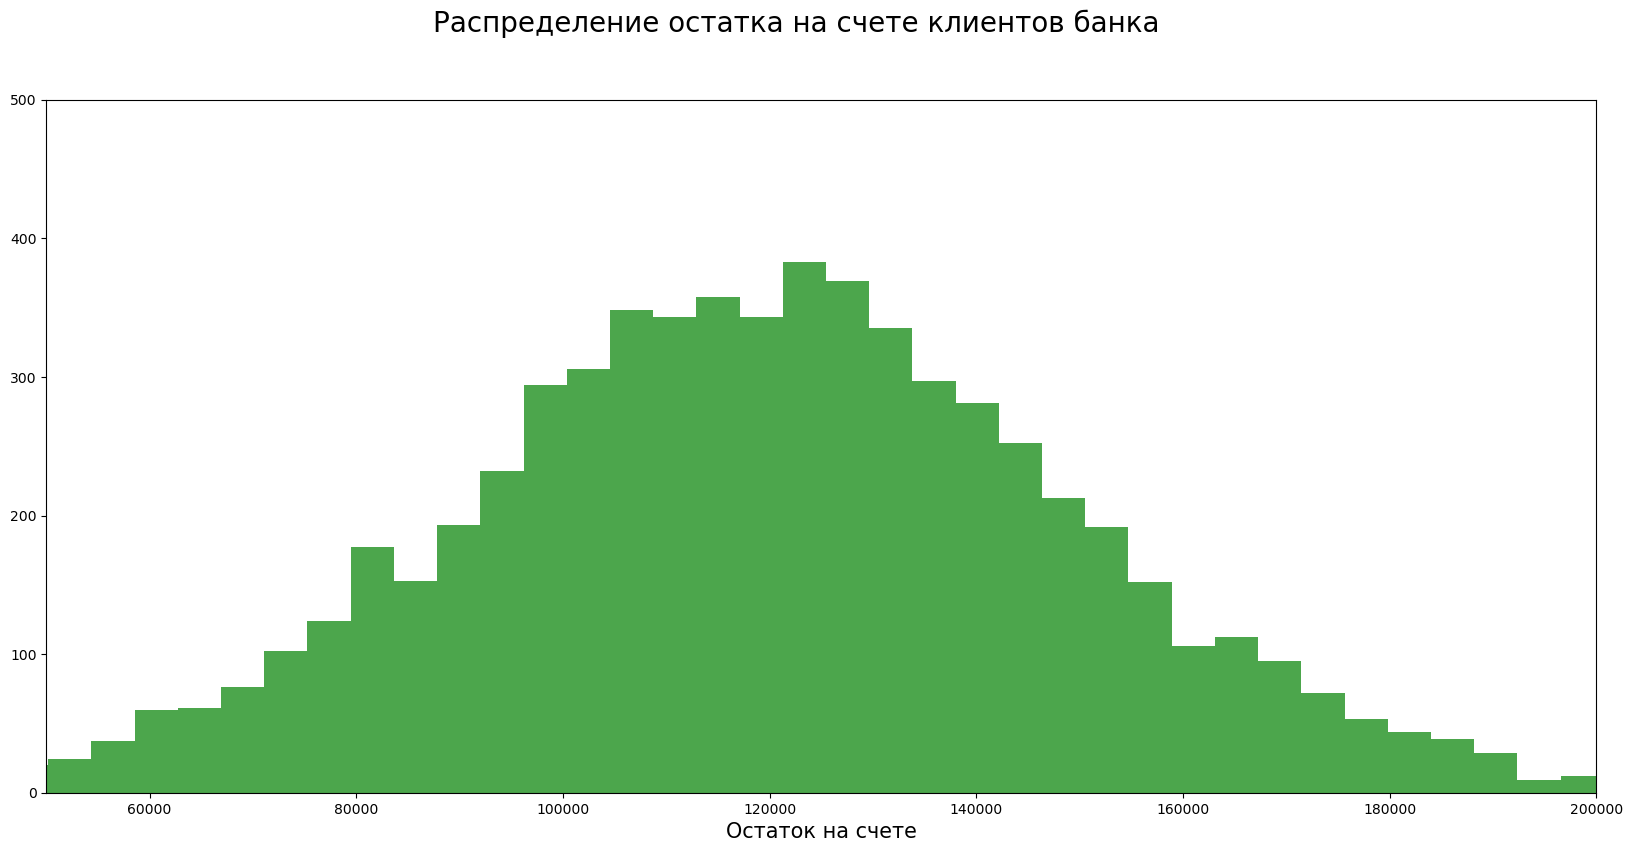

In [20]:
fig, axes = plt.subplots(figsize=(20, 9))

fig.suptitle('Распределение остатка на счете клиентов банка', fontsize=20)

axes = plt.subplot()
axes.hist(df_churn['Balance'], 60, facecolor='g', alpha=0.7)

axes.set_xlabel('Остаток на счете', fontsize=15)

axes.set_xlim(xmin=50000, xmax=200000)
axes.set_ylim(ymax=500)
plt.show()

Столбец `EstimatedSalary` указывает на предполагаемое значение заработной платы клиентов банка.

In [21]:
df_churn['EstimatedSalary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

C:\Users\roma_\AppData\Local\Temp\ipykernel_9096\3803298966.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)


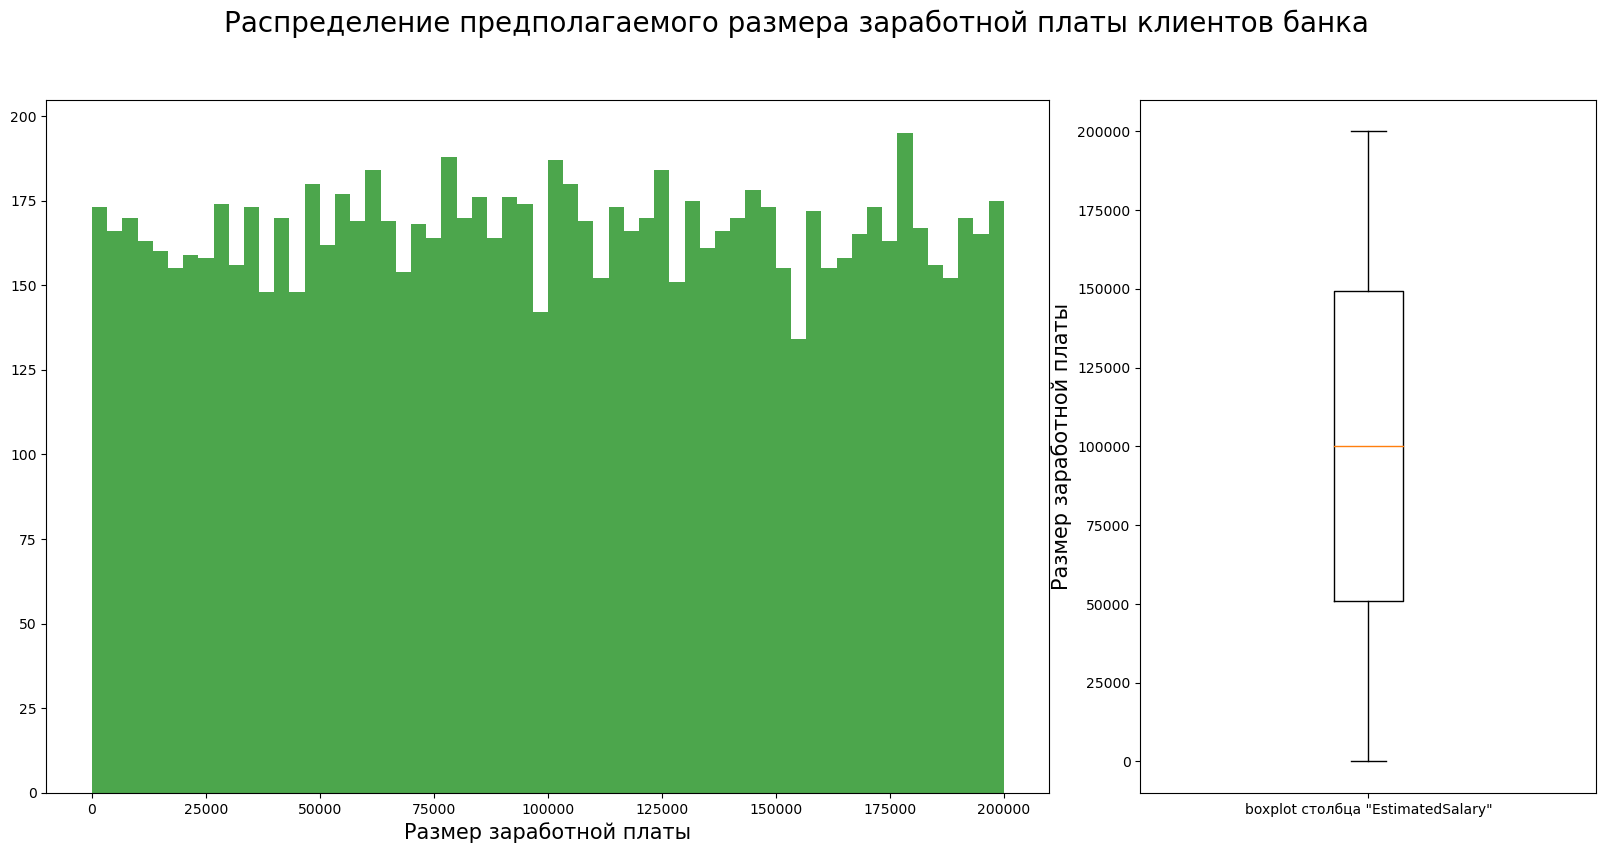

In [22]:
fig, (ax_1, ax_2) = plt.subplots(2, figsize=(20, 9))

fig.suptitle('Распределение предполагаемого размера заработной платы клиентов банка', fontsize=20)

ax_1 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=3)
ax_2 = plt.subplot2grid((3, 3), (0, 2), rowspan=3)

ax_1.hist(df_churn['EstimatedSalary'], 60, facecolor='g', alpha=0.7)
ax_2.boxplot(df_churn['EstimatedSalary'])

plt.xticks([1], ['boxplot столбца "EstimatedSalary"'])

ax_1.set_xlabel('Размер заработной платы', fontsize=15)
ax_2.set_ylabel('Размер заработной платы', fontsize=15)

plt.show()

Распределение заработной платы в датасете представлено равномерное. 

Проанализировав предоставленные данные может заключить об отличном их качестве, отсутствии аномалий, дубликатов, нормальном распределении. Важно отметить, что количественные переменные имеют разный масштаб, что важно учитывать при обучении модели. Это хороший залог для предстоящего обучения нашей модели. Но прежде подготовим параметры для обучения.

### Работа с параметрами датасета

In [23]:
iycyvuopnno

NameError: name 'iycyvuopnno' is not defined

Первое что нужно нужно сделать, это исключить из датасета столбцы `'RowNumber', 'CustomerId', 'Surname'`, данные в которых не являются информативными, потому лучше сразу от них избавиться.

In [24]:
df_churn = df_churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Из общего датасета выделим обучающую, валидационноу и тестовую выборки, применив функцию `train_test_split()`.Соотношение размера выборок определим, как 60%:20%:20%, соответственно, обучающая:валидационная:тестовая.
Воспользуемся параметром `stratify=df_churn['Exited']`, это позволит сохранить изначальное распределение таргетов во всех новых датасетах.

In [25]:
churn_train_and_valid, churn_test = \
train_test_split(df_churn, test_size=0.2, random_state=12345, stratify=df_churn['Exited'])

churn_train, churn_valid = \
train_test_split(churn_train_and_valid, test_size=0.25, random_state=12345, stratify=churn_train_and_valid['Exited'])

Далее отделим целевой признак от остальных для наших выборок. 

In [26]:
target_train = churn_train['Exited']
features_train = churn_train.drop('Exited', axis=1)

target_valid = churn_valid['Exited']
features_valid = churn_valid.drop('Exited', axis=1)

target_test = churn_test['Exited']
features_test = churn_test.drop('Exited', axis=1)

Как мы заметили ранее у количественных признаков наблюдается разный размах данных, с помощью метода `StandardScaler()`приведем признаки к единому масштабу. Тестовую выборку отложим до этапа тестирования лучшей модели.

In [27]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'NumOfProducts']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Далее преобразуем техникой прямого и порядкового кодирования категориальные признаки в численные для наших моделей.

In [28]:
categories = ['Geography', 'Gender']

In [ ]:
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), categories), remainder='passthrough', verbose_feature_names_out='False')

In [ ]:
transformed = transformer.fit_transform(features_train)
features_train_ohe = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

transformed = transformer.transform(features_valid)
features_valid_ohe = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

transformed = transformer.transform(features_test)
features_test_ohe = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

In [ ]:
transformer_oe = make_column_transformer((OrdinalEncoder(), categories), remainder='passthrough', verbose_feature_names_out='False')

In [ ]:
transformed = transformer_oe.fit_transform(features_train)
features_train_oe = pd.DataFrame(transformed, columns=transformer_oe.get_feature_names_out())

transformed = transformer_oe.transform(features_valid)
features_valid_oe = pd.DataFrame(transformed, columns=transformer_oe.get_feature_names_out())

transformed = transformer_oe.transform(features_test)
features_test_oe = pd.DataFrame(transformed, columns=transformer_oe.get_feature_names_out())

Проверим долю строк в сформированных датасетах от их общего количества в исходной датафрейме.

In [29]:
print(f'Доля строк от общего количества в обучающей выборке: {len(features_train) / len(df_churn):.2f} \
\nДоля строк от общего количества в валидационной выборке: {len(features_valid) / len(df_churn):.2f} \
\nДоля строк от общего количества в тестовой выборке: {len(features_test) / len(df_churn):.2f}')

Доля строк от общего количества в обучающей выборке: 0.60 
Доля строк от общего количества в валидационной выборке: 0.20 
Доля строк от общего количества в тестовой выборке: 0.20


В результате проведенной работы с признаками мы имеем набор датасетов, приведенных к единому масштабу в количественных признаков, категориальные признаки приведены к численным, отсеяны непоказательные признаки. 

Проведем эксперимент с Pipeline.

In [58]:
def objective(trial):
    
    classifier_name = trial.suggest_categorical("classifier", ["Logistic", "Tree", "Forest"])
    
    if classifier_name == "Logistic":
        logreg_s = trial.suggest_categorical('solver' , ['lbfgs','liblinear'])
        categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
        model = LogisticRegression(solver=logreg_s)
        
    
    
    elif classifier_name == "Tree":
        dt_md = trial.suggest_int('max_depth', 2, 20)
        dt_sl = trial.suggest_int('min_inst', 1, 32)
        categorical_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])
        model = DecisionTreeClassifier(max_depth=dt_md, min_samples_leaf=dt_sl, random_state=12345)
        
    else:
        rf_md = trial.suggest_int("rf_md", 2, 25, log=True)
        rf_n_estimators = trial.suggest_int('rf_num_estimators', 5, 100)
        categorical_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])
        model = RandomForestClassifier(max_depth=rf_md, n_estimators=rf_n_estimators, random_state=12345)

        
                                                  
    preprocessor = make_column_transformer((categorical_transformer, categories), remainder='passthrough', verbose_feature_names_out=False)
    
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
                                                

    score = cross_val_score(pipe, features_train, target_train, scoring='f1', cv=5)
    f1_mean = score.mean() 
    return f1_mean

In [59]:
study = optuna.create_study(direction="maximize") 
study.optimize(objective, n_trials=30)

[I 2023-07-26 00:07:49,349] A new study created in memory with name: no-name-9c94cc1d-5622-459f-9d2c-fb27c85ce325
[I 2023-07-26 00:07:49,694] Trial 0 finished with value: 0.3092737103960145 and parameters: {'classifier': 'Logistic', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.3092737103960145.
[I 2023-07-26 00:07:52,655] Trial 1 finished with value: 0.23810453528510916 and parameters: {'classifier': 'Forest', 'rf_md': 2, 'rf_num_estimators': 97}. Best is trial 0 with value: 0.3092737103960145.
[I 2023-07-26 00:07:52,863] Trial 2 finished with value: 0.3092737103960145 and parameters: {'classifier': 'Logistic', 'solver': 'liblinear'}. Best is trial 0 with value: 0.3092737103960145.
[I 2023-07-26 00:07:53,169] Trial 3 finished with value: 0.3092737103960145 and parameters: {'classifier': 'Logistic', 'solver': 'lbfgs'}. Best is trial 0 with value: 0.3092737103960145.
[I 2023-07-26 00:07:53,425] Trial 4 finished with value: 0.5425145083115871 and parameters: {'classifier': 'Tree', 'm

In [60]:
trial = study.best_trial
trial

FrozenTrial(number=28, state=TrialState.COMPLETE, values=[0.5652303528770347], datetime_start=datetime.datetime(2023, 7, 26, 0, 8, 48, 91038), datetime_complete=datetime.datetime(2023, 7, 26, 0, 8, 51, 166131), params={'classifier': 'Forest', 'rf_md': 25, 'rf_num_estimators': 33}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('Logistic', 'Tree', 'Forest')), 'rf_md': IntDistribution(high=25, log=True, low=2, step=1), 'rf_num_estimators': IntDistribution(high=100, log=False, low=5, step=1)}, trial_id=28, value=None)

In [61]:
trial.params

{'classifier': 'Forest', 'rf_md': 25, 'rf_num_estimators': 33}

## Работа с моделями

### Обучение и предсказания моделей по несбалансированной классовой выборке

В первую очередь обучим и проверим на валидационной выборке модель "логистической регрессии" пока без балансировки классов. 

In [ ]:
best_model_logisticregression = None
best_result_logisticregression = 0

for itr in range(100, 2001, 100):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=itr)
    model.fit(features_train_ohe, target_train)
    predictions = model.predict(features_valid_ohe)
    result = f1_score(target_valid, predictions)
    if result > best_result_logisticregression:
        best_model_logisticregression = model
        best_result_logisticregression = result
        best_max_iter = itr
        precision = precision_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
print(f'F1-оценка лучшей модели: {best_result_logisticregression} \
\nЛучшее значение гиперпарметра "max_iter": {best_max_iter} \
\nТочность лучшей модели: {precision} \
\nПолнота лучшей модели: {recall}')   

Сравним модель со случайной, построив ROC-кривую, и посчитаем площадь под кривой - AUC-ROC.

In [ ]:
probabilities_valid = best_model_logisticregression.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая модели LogisticRegression")

plt.show()

In [ ]:
print('Площадь области по ROC-кривой (AUC-ROC):', roc_auc_score(target_valid, probabilities_one_valid))

Фиксируем невысокий результат F1-метрики модели "логистической регрессии", особо отметим неудачные показатели модели в полноте предсказания положительного класса, при этом модель заметно лучше константной модели.
Следующей моделью выберем модель "дерева-решений", о чем нам говорит метрика AUC-ROC, измеряющая площадь под областью ROC-кривой, которая определяет соотношение между истинно- и ложноположительными ответами модели.

In [ ]:
best_model_decisiontree = None
best_result_decisiontree = 0

for depth in range(1, 31):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_result_decisiontree:
        best_model_decisiontree = model
        best_result_decisiontree = result
        best_max_depth = depth
        precision = precision_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
                
print(f'F1-оценка лучшей модели: {best_result_decisiontree} \
\nЛучшее значение гиперпараметра "max_depth": {best_max_depth} \
\nТочность лучшей модели: {precision} \
\nПолнота лучшей модели: {recall}')

F1-оценка модели "дерева-решений" заметно лучше - 0.5817, почти половина положительного класса было верно предсказано моделью. 

In [ ]:
probabilities_valid = best_model_decisiontree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая модели DecisionTreeClassifier")

plt.show()

In [ ]:
print('Площадь области по ROC-кривой (AUC-ROC):', roc_auc_score(target_valid, probabilities_one_valid))

Модель "дерева-решений" улучшила показатель площади под ROC-кривой в сравнении с моделью "логистической регрессии". Далее обратимся к модели "случайного леса".

In [ ]:
%%time

best_model_randomforest = None
best_result_randomforest = 0

for est in range(10, 201, 10):
    for depth in range(1, 31):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        if result > best_result_decisiontree:
            best_model_randomforest = model
            best_result_randomforest = result
            best_max_depth = depth
            best_n_estimators = est
            precision = precision_score(target_valid, predictions)
            recall = recall_score(target_valid, predictions)
print(f'F1-оценка лучшей модели: {best_result_randomforest} \
\nЛучшее значение гиперпарметра "n_estimators": {best_n_estimators} \
\nЛучшее значение гиперпараметра "max_depth": {best_max_depth} \
\nТочность лучшей модели: {precision} \
\nПолнота лучшей модели: {recall}')

И "случайный лес" показал неплохую оценку F1-метрики и рекордную точность, хотя несколько ниже показатели полноты в сравнении с моделью "дерева-решений".

In [ ]:
probabilities_valid = best_model_randomforest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая RandomForestClassifier")

plt.show()

In [ ]:
print('Площадь области по ROC-кривой (AUC-ROC):', roc_auc_score(target_valid, probabilities_one_valid))

"Случайный лес" выглядит предпочтительно и по результатам построения ROC-кривой.

Модели "случайного леса" и "дерева-решений" и на несбалансированной выборке показали неплохой результат. Стоит рассчитывать, что балансировка классов придаст большую полноту предсказаний положительного класса, отсюда получим лучшие показания метрики F1.
Отмечаем прогресс в показателях AUC-ROC от модели "логистичкской регрессии" к "случайному лесу".

Сделаем подбор гиперпараметров с помощью фреймворка Optuna

In [ ]:
def objective(trial):
    
    classifier_name = trial.suggest_categorical("classifier", ["Tree", "Forest"])
    
    
    if classifier_name == "Tree":
        dt_md = trial.suggest_int('max_depth', 2, 20)
        dt_sl = trial.suggest_int('min_inst', 1, 32)
        model = DecisionTreeClassifier(max_depth=dt_md, min_samples_leaf=dt_sl, random_state=12345)
        
    else:
        rf_md = trial.suggest_int("rf_md", 2, 25, log=True)
        rf_n_estimators = trial.suggest_int('rf_num_estimators', 5, 100) 
        model = RandomForestClassifier(max_depth=rf_md, n_estimators=rf_n_estimators, random_state=12345)
        
   
    
    model.fit(features_train_oe, target_train)
    predictions = model.predict(features_valid_oe)
    result = f1_score(target_valid, predictions)
    return result

In [ ]:
study = optuna.create_study(direction="maximize") 
study.optimize(objective, n_trials=30)

In [ ]:
trial = study.best_trial
trial

In [ ]:
trial.params

### Обучение и предсказания моделей по сбалансированным классовым выборкам

Модель логистической регрессии сбалансируем с помощью придания меньшему положительному классу большего веса с помощью параметра `class_weight` и его значения `balanced`.

In [ ]:
best_model_logisticregression = None
best_result_logisticregression = 0

model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = f1_score(target_valid, predictions)
if result > best_result_logisticregression:
        best_model_logisticregression = model
        best_result_logisticregression = result
        precision = precision_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
print(f'F1-оценка лучшей модели: {best_result_logisticregression} \
\nТочность лучшей модели: {precision} \
\nПолнота лучшей модели: {recall}')   

Сбалансированная модель показала себя отлично, и улучшила свой результат, но не превзошла показатели двух других моделей. Построим график ROC-кривой и вычислим площадь по кривой (AUC-ROC).

In [ ]:
probabilities_valid = best_model_logisticregression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая модели LogisticRegression")

plt.show()

In [ ]:
print('Площадь области по ROC-кривой (AUC-ROC):', roc_auc_score(target_valid, probabilities_one_valid))

Показатели AUC-ROC хоть и незначительно, но улучшились. Модель эффективнее работает на сбалансированной выборке. Продолжим обучением моделей "дерева-решений" и "случайного леса" на сбалансированной выборке.

Использует значение `balanced` параметра `class_weight` для деревянных моделях.

In [ ]:
best_model_decisiontree = None
best_result_decisiontree = 0

for depth in range(1, 31):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_result_decisiontree:
        best_model_decisiontree = model
        best_result_decisiontree = result
        best_max_depth = depth
        precision = precision_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
                
print(f'F1-оценка лучшей модели: {best_result_decisiontree} \
\nЛучшее значение гиперпараметра "max_depth": {best_max_depth} \
\nТочность лучшей модели: {precision} \
\nПолнота лучшей модели: {recall}')

In [ ]:
probabilities_valid = best_model_decisiontree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая модели DecisionTreeClassifier")

plt.show()

In [ ]:
print('Площадь области по ROC-кривой (AUC-ROC):', roc_auc_score(target_valid, probabilities_one_valid))

Ожидаемо при балансировке классов путем придания их равного веса мы снизили точность, зато заметно прибавили в полноте наших предсказаний, показатель площади под ROC-кривой вырос, а вот метрика F1 несколько ухудшилась, по сравнению той же модели "дерева-решений", но на несбалансированной выборке.

Перейдем к обучению модели "случайного леса".

In [ ]:
%%time

best_model_randomforest = None
best_result_randomforest = 0

for est in range(10, 201, 10):
    for depth in range(1, 31):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        if result > best_result_decisiontree:
            best_model_randomforest = model
            best_result_randomforest = result
            best_max_depth = depth
            best_n_estimators = est
            precision = precision_score(target_valid, predictions)
            recall = recall_score(target_valid, predictions)
print(f'F1-оценка лучшей модели: {best_result_randomforest} \
\nЛучшее значение гиперпарметра "n_estimators": {best_n_estimators} \
\nЛучшее значение гиперпараметра "max_depth": {best_max_depth} \
\nТочность лучшей модели: {precision} \
\nПолнота лучшей модели: {recall}')

Модель показала хороший результат, при этом несколько ниже своего собственного на несбалансированной выборке.

In [ ]:
probabilities_valid = best_model_randomforest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая RandomForestClassifier")

plt.show()

In [ ]:
print('Площадь области по ROC-кривой (AUC-ROC):', roc_auc_score(target_valid, probabilities_one_valid))

А вот метрика AUC-ROC показала прогресс модели.

Подготовим и обучим модели сбалансировав долю классов.

Учитывая размер выборки будет более уместным для балансировки классов использовать технику **upsampling**, мы увеличим долю положительного класса в обучающей выборке, таким образом лучше познакомим нашу модель с представителями положительного класса. Составим функцию, а прежде найдем множитель для уравнивания классов.

In [ ]:
len(target_train[target_train == 0])/ len(target_train[target_train == 1])

Почти в 4 раза больше в выборке объектов отрицательного класса, этот множитель и оставим для нашей функции.

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [ ]:
best_model_logisticregression = None
best_result_logisticregression = 0

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predictions = model.predict(features_valid)
result = f1_score(target_valid, predictions)
if result > best_result_logisticregression:
        best_model_logisticregression = model
        best_result_logisticregression = result
        precision = precision_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
print(f'F1-оценка лучшей модели: {best_result_logisticregression} \
\nТочность лучшей модели: {precision} \
\nПолнота лучшей модели: {recall}')  

In [ ]:
probabilities_valid = best_model_logisticregression.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая модели LogisticRegression")

plt.show()

In [ ]:
print('Площадь области по ROC-кривой (AUC-ROC):', roc_auc_score(target_valid, probabilities_one_valid))

Модель "логистической регрессии" показала себя несколько хуже в рамках F1-оцене, чем на сбалансированном взвешивании классов.

Обучим и найдем показатель F1-метрики лучшей модели "дерева-решений", обученной на сбалансированной выборке.

In [ ]:
best_model_decisiontree = None
best_result_decisiontree = 0

for depth in range(1, 31):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_result_decisiontree:
        best_model_decisiontree = model
        best_result_decisiontree = result
        best_max_depth = depth
        precision = precision_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
                
print(f'F1-оценка лучшей модели: {best_result_decisiontree} \
\nЛучшее значение гиперпараметра "max_depth": {best_max_depth} \
\nТочность лучшей модели: {precision} \
\nПолнота лучшей модели: {recall}')

In [ ]:
probabilities_valid = best_model_decisiontree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая модели DecisionTreeClassifier")

plt.show()

In [ ]:
print('Площадь области по ROC-кривой (AUC-ROC):', roc_auc_score(target_valid, probabilities_one_valid))

Сбалансированная выборка несколько хуже сказалась на результаты модели "дерева-решений", метрики F1 ниже, чем у той же модели на несбалансированной выборке. Интересно, какие результаты мы увидим у модели "случайного леса".

In [ ]:
%%time

best_model_randomforest = None
best_result_randomforest = 0

for est in range(10, 601, 20):
    for depth in range(1, 101, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        if result > best_result_decisiontree:
            best_model_randomforest = model
            best_result_randomforest = result
            best_max_depth = depth
            best_n_estimators = est
            precision = precision_score(target_valid, predictions)
            recall = recall_score(target_valid, predictions)
print(f'F1-оценка лучшей модели: {best_result_randomforest} \
\nЛучшее значение гиперпарметра "n_estimators": {best_n_estimators} \
\nЛучшее значение гиперпараметра "max_depth": {best_max_depth} \
\nТочность лучшей модели: {precision} \
\nПолнота лучшей модели: {recall}')

In [ ]:
probabilities_valid = best_model_randomforest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая RandomForestClassifier")

plt.show()

In [ ]:
print('Площадь области по ROC-кривой (AUC-ROC):', roc_auc_score(target_valid, probabilities_one_valid))

Модель "случайного леса" показала лучшие результаты на сбалансированной выборке, впервые за время обучения одна из моделей преодолела плану в 0,6 значения F1-метрики, руководствуюсь ее показателями и площади под ROC-кривой именно данную модель мы выбираем для финального тестирования.

По результатам обучения моделей на сбалансированной и несбалансированной выборках однозначно выделяются в лучшую сторону модели, обученные на сбалансированной выборкой. В среднем же модели показали неплохой результат, намного лучше константной модели случайного предсказания, что говорит о вменяемости каждой модели.

Для обучения модели и проверки алгоритмов мы использовали такие техники балансировки, как взвешивание классов и upsampling. Искали лучшие модели использую перебор гиперпараметром n_estimators, max_depth и max_iter.

Сделаем подбор гиперпараметров с помощью фреймворка Optuna

In [ ]:
def objective(trial):
    
    classifier_name = trial.suggest_categorical("classifier", ["Tree", "Forest"])
    
    
    if classifier_name == "Tree":
        dt_md = trial.suggest_int('max_depth', 2, 20)
        dt_sl = trial.suggest_int('min_inst', 1, 32)
        model = DecisionTreeClassifier(max_depth=dt_md, min_samples_leaf=dt_sl, random_state=12345, class_weight='balanced')
        
    else:
        rf_md = trial.suggest_int("rf_md", 2, 25, log=True)
        rf_n_estimators = trial.suggest_int('rf_num_estimators', 5, 100) 
        model = RandomForestClassifier(max_depth=rf_md, n_estimators=rf_n_estimators, random_state=12345, class_weight='balanced')
        
   
    
    model.fit(features_train_oe, target_train)
    predictions = model.predict(features_valid_oe)
    result = f1_score(target_valid, predictions)
    return result

In [ ]:
study = optuna.create_study(direction="maximize") 
study.optimize(objective, n_trials=30)

In [ ]:
trial = study.best_trial
trial

In [ ]:
trial.params

In [ ]:
trial.values

## Проверка лучшей модели

### Проверка лучшей модели на тестовой выборке

Лучшей моделью мы признали модель "случайного леса" на сбалансированной выборке. Протестируем наилучшую модель.

In [ ]:
predictions = best_model_randomforest.predict(features_test)

result = f1_score(target_test, predictions)
precision = precision_score(target_test, predictions)
recall = recall_score(target_test, predictions)
print(f'F1-оценка лучшей модели: {result} \
\nТочность лучшей модели: {precision} \
\nПолнота лучшей модели: {recall}')

In [ ]:
probabilities_valid = best_model_randomforest.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC-кривая RandomForestClassifier")

plt.show()

In [ ]:
print('Площадь области по ROC-кривой (AUC-ROC):', roc_auc_score(target_test, probabilities_one_valid))

При проверке на тестовой выборке модель продемонстрировала отличный результат - 0.59. AUC-ROC показывает ценность и вменяемость выбранной модели "случайного леса".

### Сравнение с константной моделью

Сравним предсказания лучшей модели с показателями константой модели. С помощью класса `DummyClassifier()` создадим модель на все объекты отвечающей "1", т.е. модель предсказывает отток каждого клиента в датасете. Таким образом мы можем понять насколько ценна и эффективна наша модель.

In [ ]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
predictions = dummy_model.predict(features_test)

f1_score = f1_score(target_test, predictions)
precision = precision_score(target_test, predictions)

print(f'F1-оценка константной модели: {f1_score} \
\nТочность константной модели: {precision}')

Как видим из показателей константной модели, наша модель работает несравнимо эффективнее и точнее. Созданная модель "случайного леса" предсказывает более 55% клиентов, решивших уйти, на тестовой выборке. 

## Вывод

 В ходе данной работы для предсказания положительного класса, а именно предсказания поведения клиентов, решивших попрощаться с банком, был создан ценный инструмент для борьбы с оттоком клиентов.

 В ходе исследования была выявлена лучшая модель алгоритма "случайного леса". Модель показала отличные показатели точности и полноты на тестовой выборке, в частности доля более чем в 55% положительного класса была предсказана верно, это именно те клиенты, которые решили покинуть банк. В данной задаче полнота имеет большую ценность, поскольку нам важно, как можно больше клиентов, принявших решение об уходе из банка выявить с помощью данной модели, совсем нестрашно, если мы неточностью попадем в клиента, не думавшем об расторжении договора с банком, и предоставим ему выгодную программу лояльности, которая будет способствовать повышению лояльности клиента.
 
 Модель показала отличный результат в среднем гармоническом отношении полноты и точности - F1, это говорит о том, что модель хороша и в точности и полноте предсказания положительного класса.

 Как мы выяснили в ходе исследования, в банке присутствует большое количество клиентов, которые имеют нулевой баланс и не пользуются счетом. Рекомендуется, помимо программы по предотвращению оттока клиентов, с которой можно справится с помощью нашей модели, внедрять меры и стимулы для начала активности спящих клиентов. В большинстве - это теплые клиенты, которые будут идти на контакт и проявлять готовность выслушать предложение банка. Здесь, как кажется, есть потенциал для роста числа активных клиентов и увеличения оборотов по клиентским счетам.